## Import Libraries

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns
import numpy as np
import shutil
import os

In [4]:
ORIG_INPUT_DATASET = "House_Room_Dataset/Bedroom"

TRAIN = "training"
VAL = "evaluation"
TEST = "validation"

BASE_PATH = "dataset"
BATCH_SIZE = 32
CLASSES = ["Modern", "Old"]

In [5]:
def plot_hist(hist, metric):
    if metric == 'auc':
        plt.plot(hist.history["auc"])
        plt.plot(hist.history["val_auc"])
    else:
        plt.plot(hist.history["loss"])
        plt.plot(hist.history["val_loss"])
    plt.style.use("ggplot")
    plt.title("model {}".format(metric))
    plt.ylabel("{}".format(metric))
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [6]:
# Reading labels from the txt file
with open("labels.txt", 'r') as f:
      manual_labels = f.read()
        
# Extracting individual labels into a list
labels = [i for i in manual_labels]
len(labels)

452

In [7]:
from collections import Counter
print(Counter(labels).keys()) 
print(Counter(labels).values())

dict_keys(['O', 'M', '\n'])
dict_values([271, 180, 1])


In [8]:
labels.pop()

'\n'

In [9]:
len(labels)

451

In [12]:
# sorting files in the order they appear
files = os.listdir(ORIG_INPUT_DATASET)
files.sort(key=lambda f: int(f.split('_')[1].split('.')[0]))

# checking to see the correct file order
files[:5]

['bed_1.jpg', 'bed_2.jpg', 'bed_3.jpg', 'bed_4.jpg', 'bed_8.jpg']

In [13]:
# splitting files into train and test sets
trainX, testX, trainY, testY =  train_test_split(files[:len(labels)], labels,stratify=labels, train_size=0.90)

# further splitting of train set into train and val sets
trainX, valX, trainY, valY = train_test_split(trainX, trainY, stratify=trainY, train_size=0.85)

# Checking the size of train, test, eval
len(trainX), len(trainY), len(valX), len(valY),  len(testX), len(testY)

(344, 344, 61, 61, 46, 46)

In [14]:
# Building the dataset properly - 
splits = [(trainX, trainY), (testX, testY), (valX, valY)]
dirnames = ['training', 'evaluation', 'validation']

for i, (data,label) in enumerate(splits):
    outside_dir=dirnames[i]

    for j in tqdm(range(0, len(label)), desc="Iterating over images in sub folder"):
        dir = label[j]
        
        # construct the path to the sub-directory
        dirPath = os.path.join(BASE_PATH, outside_dir, dir)
        
        # if the output directory does not exist, create it
        if not os.path.exists(dirPath):
            os.makedirs(dirPath)
            
            
        # copy the img to this new directory
        src_img = os.path.join(ORIG_INPUT_DATASET, data[j])
        shutil.copy(src_img, dirPath)

Iterating over images in sub folder: 100%|████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 395.35it/s]


In [15]:
trainPath = os.path.join(BASE_PATH, TRAIN)
valPath = os.path.join(BASE_PATH, VAL)
testPath = os.path.join(BASE_PATH, TEST)

In [16]:
totalTrain = len(list(paths.list_images(trainPath)))
totalVal = len(list(paths.list_images(testPath)))
totalTest = len(list(paths.list_images(valPath)))
print(totalTrain, totalTest, totalVal)

421 88 115


**Data Augmentation**

In [17]:
trainAug = ImageDataGenerator(
rotation_range=90,
zoom_range=[0.5, 1.0],
width_shift_range=0.3,
height_shift_range=0.25,
shear_range=0.15,
horizontal_flip=True,
fill_mode="nearest",
brightness_range=[0.2, 1.0]
)

In [18]:
valAug = ImageDataGenerator()

In [19]:
testAug = ImageDataGenerator()

In [42]:
# Create training batches whilst creating augmented images on the fly
trainGen = trainAug.flow_from_directory(
    directory= 'dataset/training',
    target_size=(224,224),
#     save_to_dir='dataset/augmented/train/',
#     save_prefix='train',
    shuffle=True # data will be shuffled between epochs
)

# Create val batches 
valGen = valAug.flow_from_directory(
directory= 'dataset/validation',
target_size=(224,224),
shuffle=True
)

Found 421 images belonging to 2 classes.
Found 115 images belonging to 2 classes.


In [36]:
# Create test batches
testGen = testAug.flow_from_directory(
directory= 'dataset/evaluation',
target_size=(224,224),
shuffle=False
)

Found 88 images belonging to 2 classes.


**Transfer Learning**

Feature Extraction Step

In [24]:
baseModel = EfficientNetB0(
            weights="imagenet",
            include_top=False, # make sure top layer is not included
            input_tensor=Input(shape=(224, 224, 3)),
            pooling="avg"
           )

In [25]:
# freeze the weights
for layer in baseModel.layers:
      layer.trainable = False

In [26]:
# training a new classifier on top (Functional Keras Model)
x = baseModel.output
Layer_1 = BatchNormalization()(x)
Layer_2 = Dropout(0.5)(Layer_1)
output_layer = Dense(len(CLASSES), activation="softmax")(Layer_2)
model = Model(inputs = baseModel.input, outputs = output_layer)


In [27]:
# Another way to create the classifier on top of basemodel
model = tf.keras.Sequential()
model.add(baseModel)
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(len(CLASSES), activation="softmax"))

In [28]:
# compile
opt = Adam(learning_rate=1e-3)
model.compile(optimizer=opt, 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.AUC()]
              )

In [29]:
# implementing early stopping
es = EarlyStopping(
     monitor='val_loss',  #metric to monitor
     mode='min',  # whether to min or max the metric monitored
     patience=10, # epochs to wait before declaring stopped training
     verbose=1  # output epoch when training was stopped
     )

# implementing model checkpoint
mc = ModelCheckpoint(
      'feature_extraction.h5',
       monitor='val_loss',
       mode='min',
       verbose=1, # display epoch+accuracy everytime model is saved
       save_best_only=True
      )

In [43]:
# Training the model
hist = model.fit(
       x=trainGen,
       epochs=25,
       verbose=2,
       validation_data=valGen,
       steps_per_epoch=totalTrain // BATCH_SIZE,
       callbacks=[es, mc]
      )

Epoch 1/25
13/13 - 26s - loss: 0.9188 - auc: 0.5945 - val_loss: 0.6455 - val_auc: 0.7077

Epoch 00001: val_loss improved from inf to 0.64549, saving model to feature_extraction.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
13/13 - 20s - loss: 0.9265 - auc: 0.5872 - val_loss: 0.6280 - val_auc: 0.7910

Epoch 00002: val_loss improved from 0.64549 to 0.62802, saving model to feature_extraction.h5
Epoch 3/25
13/13 - 21s - loss: 0.8296 - auc: 0.6585 - val_loss: 0.6110 - val_auc: 0.8056

Epoch 00003: val_loss improved from 0.62802 to 0.61097, saving model to feature_extraction.h5
Epoch 4/25
13/13 - 21s - loss: 0.7748 - auc: 0.6995 - val_loss: 0.5972 - val_auc: 0.8218

Epoch 00004: val_loss improved from 0.61097 to 0.59724, saving model to feature_extraction.h5
Epoch 5/25
13/13 - 21s - loss: 0.7458 - auc: 0.7317 - val_loss: 0.5806 - val_auc: 0.8370

Epoch 00005: val_loss improved from 0.59724 to 0.58055, saving model to feature_extraction.h5
Epoch 6/25
13/13 - 22s - loss: 0.7396 - auc: 0.7367 - val_loss: 0.5660 - val_auc: 0.8479

Epoch 00006: val_loss improved from 0.58055 to 0.56595, saving model to feature_extraction.h5
Epoch 7/25
13/13 - 23s - loss: 0.7511 - auc: 0.7071 - val_loss: 0.5571 - val_auc

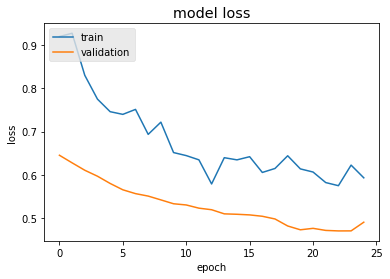

In [44]:
plot_hist(hist, metric="loss")

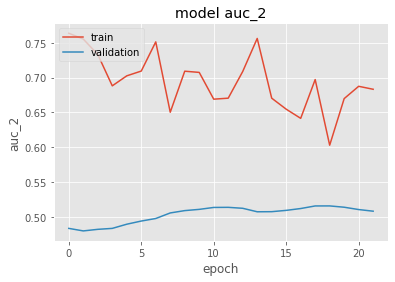

In [58]:
plot_hist(hist, metric="auc_2")

No. of test images 88
{'M': 0, 'O': 1}


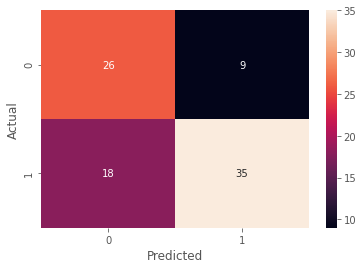

In [46]:
testGen.reset()
predIdxs = model.predict(
             x=testGen,
             steps=(totalTest // BATCH_SIZE) + 1
            )
predIdxs = np.argmax(predIdxs, axis = 1)
print("No. of test images", len(predIdxs))
print(testGen.class_indices)
cm = confusion_matrix(testGen.classes, predIdxs)
heatmap = sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [47]:
def fine_tune_model(model):
    
    # unfreeze last conv block i.e. block7a which can be found in top 20 layers
    for layer in model.layers[-20:]:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True
            
    # check which of these are trainable and which aren't
    for layer in model.layers:
        print("{}: {}".format(layer, layer.trainable))
     
     
    # compile (with an even smaller learning rate)
    opt = Adam(learning_rate=1e-5)
    model.compile(optimizer=opt, 
                loss='binary_crossentropy', 
                metrics=[tf.keras.metrics.AUC()])
    
    return model

In [48]:
trainGen.reset()
valGen.reset()
testGen.reset()

In [50]:
model_fine_tuned = fine_tune_model(model)

<keras.engine.functional.Functional object at 0x000001F2FFF288E0>: True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x000001F2FFF412B0>: True
<keras.layers.core.Dropout object at 0x000001F2FFF466D0>: True
<keras.layers.core.Dense object at 0x000001F2883C5610>: True


In [51]:
# implementing early stopping
es_tune = EarlyStopping(
     monitor='val_loss', 
     mode='min',  
     patience=20, 
     verbose=1  
     )
# implementing model checkpoint
mc_tune = ModelCheckpoint(
      'fine_tuned_house.h5',
       monitor='val_loss',
       mode='min',
       verbose=1, 
       save_best_only=True
      )
hist = model_fine_tuned.fit(
      x=trainGen,
      steps_per_epoch=totalTrain // BATCH_SIZE,
      validation_data=valGen,
      epochs=50,
      verbose=2,
      callbacks=[es_tune, mc_tune]
     )

Epoch 1/50
13/13 - 107s - loss: 0.7638 - auc_1: 0.6948 - val_loss: 0.4835 - val_auc_1: 0.8683

Epoch 00001: val_loss improved from inf to 0.48354, saving model to fine_tuned_house.h5


C:\ProgramData\Anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/50
13/13 - 95s - loss: 0.7554 - auc_1: 0.6931 - val_loss: 0.4799 - val_auc_1: 0.8721

Epoch 00002: val_loss improved from 0.48354 to 0.47990, saving model to fine_tuned_house.h5
Epoch 3/50
13/13 - 101s - loss: 0.7333 - auc_1: 0.6925 - val_loss: 0.4822 - val_auc_1: 0.8699

Epoch 00003: val_loss did not improve from 0.47990
Epoch 4/50
13/13 - 91s - loss: 0.6882 - auc_1: 0.7430 - val_loss: 0.4835 - val_auc_1: 0.8692

Epoch 00004: val_loss did not improve from 0.47990
Epoch 5/50
13/13 - 92s - loss: 0.7026 - auc_1: 0.7249 - val_loss: 0.4895 - val_auc_1: 0.8633

Epoch 00005: val_loss did not improve from 0.47990
Epoch 6/50
13/13 - 89s - loss: 0.7095 - auc_1: 0.7354 - val_loss: 0.4941 - val_auc_1: 0.8573

Epoch 00006: val_loss did not improve from 0.47990
Epoch 7/50
13/13 - 89s - loss: 0.7513 - auc_1: 0.6925 - val_loss: 0.4977 - val_auc_1: 0.8541

Epoch 00007: val_loss did not improve from 0.47990
Epoch 8/50
13/13 - 85s - loss: 0.6503 - auc_1: 0.7646 - val_loss: 0.5057 - val_auc_1: 0.

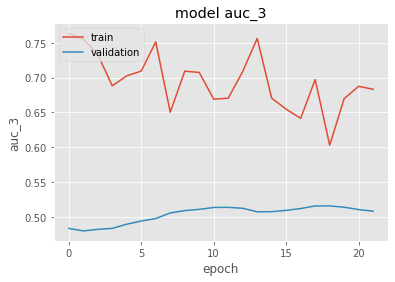

In [62]:
plot_hist(hist, metric="auc_3")

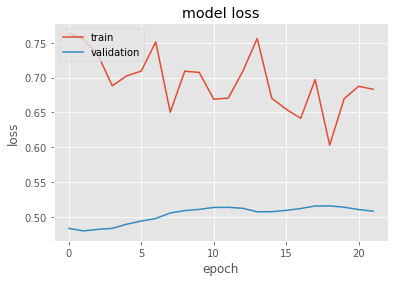

In [53]:
plot_hist(hist, metric="loss")

**Thank you**